In [2]:
import sys, os, io, json, numpy as np, random, time
#from sklearn.metrics import roc_auc_score
from importlib import reload
import extra_utils
reload(extra_utils)
from extra_utils import time_features, subpool, test_extra_predictions
import forest
reload(forest)
from forest import build_tree, EMatrix, tree2gv
import xgboost as xgb
import tensorflow as tf
import split
reload(split)
from split import SplitMaker
#from split import make_split_quick, make_gax, split_quick_graph, split_quick_graph_transpose
import graphviz
from sklearn import metrics

/home/zomb-vision/envs/env35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zomb-vision/envs/env35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zomb-vision/envs/env35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zomb-vision/envs/env35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zomb-vision/envs/env35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zomb-visi

In [3]:
split_maker_old = SplitMaker.make_split_old()

In [4]:
pool = np.load('../prepare_dataset/pool_cross_00.npz')
features_bool, f_time, label_orig = (pool[name] for name in ['features', 'f_time', 'label'])
label = label_orig

In [5]:
np.random.seed(42)
features_orig = np.random.normal(loc=features_bool*1.0, scale=0.01)
#features = features[:150000,:]; label = label_orig[:150000, :]

f_test, l_test = features_orig[150000:,:], label_orig[150000:, :]
features = features_orig[:150000,:]; label = label_orig[:150000, :]

### Тестирование инвариантности сплита относительно замены местами столбцов фичей

```
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

%%time
split_maker_old.split(np.zeros(label.shape), features, label)
#make_split(np.zeros(label.shape), features, label)

%%time
split_maker_old.split(np.zeros(label.shape), features_swap, label)
#make_split(np.zeros(label.shape), features_swap, label)
```

In [73]:
features.shape, label.shape

((150000, 17), (150000, 1))

In [58]:
global_ax = split_maker_old.make_gax(features)
featuresT = features.T
global_axT = global_ax.T

In [59]:
split_maker = SplitMaker.make_split_new(reduce_axis=0, make_transpose=True)

In [60]:
%%time
start_params = {'max_depth': 8, 'learning_rate':0.3, 'transposed_feature1111': 1, 'unbalanced_penalty':0.001}
tf.constant
forest.time1 = forest.time2 =0
forest.time3 = []
with tf.Session(graph=split_maker.graph) as s:
    tree = build_tree(start_params, EMatrix(featuresT if split_maker.reduce_axis==1 else features, 
                                            label, np.zeros(label.shape), 
                                            gax=global_axT if split_maker.reduce_axis==1 else global_ax, 
                                            splitgax=True), split_maker=split_maker, sess=s)
print("\nsplit time = {:.5f}, {:.5f}, [{}]".format(forest.time1, forest.time2, ", ".join("{:.5f}".format(tt) for tt in forest.time3)), file=sys.stderr)
tree_arrays = forest.init_arrays(tree, forest.init_id(tree))

1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  

CPU times: user 6.46 s, sys: 257 ms, total: 6.71 s
Wall time: 2.5 s


4  5  5  
split time = 6.55365, 0.11795, [0.58596, 0.25116, 0.13560, 0.07351, 0.04669, 0.03291, 0.02687, 0.02711, 0.01508, 0.01744, 0.01889, 0.01417, 0.02827, 0.02848, 0.02630, 0.01662, 0.01577, 0.01514, 0.01591, 0.04806, 0.03592, 0.02465, 0.02180, 0.01871, 0.02433, 0.02567, 0.01558, 0.02477, 0.02339, 0.01980, 0.01852, 0.01805, 0.01651, 0.01607, 0.07438, 0.07061, 0.03405, 0.02698, 0.01675, 0.02351, 0.02901, 0.02172, 0.02158, 0.03850, 0.03315, 0.02271, 0.02419, 0.02087, 0.02068, 0.01780, 0.02369, 0.02280, 0.02060, 0.01844, 0.01822, 0.01840, 0.01749, 0.01637, 0.01742, 0.01322, 0.01485, 0.01506, 0.01680, 0.01499, 0.01718, 0.14548, 0.10947, 0.10134, 0.05596, 0.03497, 0.02457, 0.02242, 0.03180, 0.02640, 0.01979, 0.05634, 0.05138, 0.02558, 0.03092, 0.02421, 0.01918, 0.01951, 0.02813, 0.02514, 0.02531, 0.02180, 0.01760, 0.01596, 0.01702, 0.01828, 0.01996, 0.01607, 0.01475, 0.01600, 0.01599, 0.01724, 0.01600, 0.04095, 0.03849, 0.03333, 0.03359, 0.03432, 0.01738, 0.01870, 0.01606, 0.01819, 0.01

In [61]:
import pstats
p = pstats.Stats('build_tree.prof')
#p.sort_stats('tottime').print_stats()

In [62]:
pred = forest.tree_apply(tree_arrays, features)
pred_test = forest.tree_apply(tree_arrays, f_test)
auc1l = metrics.roc_auc_score(label[:, 0], pred)
auc1t = metrics.roc_auc_score(label[:, 0], pred_test)
auc0 = metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))
auc1l, auc1t, auc0

(0.564954307935, 0.5019091667880746, 0.5)

In [63]:
#tree.left.left.left.left.val, tree.val
tree.left.left

In [64]:
#forest.tree2gv(tree)

In [65]:
%%time
boost_params = {'max_depth': 4, 'learning_rate':0.3, 'splitgax': True, 'transposed_feature': 0, 'unbalanced_penalty':0.001}
booster = forest.train(boost_params, EMatrix(featuresT if boost_params['transposed_feature'] else features, label), num_boost_round=10)


0 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
1 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
2 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
3 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
4 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
5 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
6 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
7 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
8 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
9 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  

CPU times: user 17.6 s, sys: 76.9 ms, total: 17.7 s
Wall time: 6.85 s


In [66]:
####################################################

In [67]:
#%%time
#gax13 = make_gax(features)
#print(gax13.shape)

In [68]:
pred2 = booster.predict(features)
pred2b = booster.predict(features, tree_limit=10)
pred_test = booster.predict(f_test)
main_auc_l = metrics.roc_auc_score(label[:, 0], pred2)
main_auc_t = metrics.roc_auc_score(l_test[:, 0], pred_test)
main_auc_l, main_auc_t

(0.5605287476686079, 0.5402890562386409)

In [17]:
0.5783850422568331,0.547297544877569

(0.5783850422568331, 0.547297544877569)

In [18]:
#np.min(pred2b), np.max(pred2b)

In [19]:
tree2gv(booster.forest[45][0])

NameError: name 'tree2gv' is not defined

In [20]:
dmat = xgb.DMatrix(features, label)

In [22]:
%%time
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=10)

[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:00:48] /work

In [23]:
dmat_test = xgb.DMatrix(f_test, l_test)

In [24]:
pred_fast = model.predict(dmat)
pred_test = model.predict(dmat_test)

metrics.roc_auc_score(label[:, 0], pred_fast), metrics.roc_auc_score(l_test[:, 0], pred_test)

(0.564382620107551, 0.5476151803114241)

In [ ]:
pred_fast = model.predict(dmat, ntree_limit=35)
metrics.roc_auc_score(label[:, 0], pred_fast)

In [ ]:
pred2b = booster.predict(features, tree_limit=15)
metrics.roc_auc_score(label[:, 0], pred2b)

In [ ]:
0.5987831226886691, 0.5457320402572653

In [ ]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

In [ ]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

In [ ]:
model.dump_model('xgb.dump')

In [ ]:
tree2gv(booster.forest[1][0])

In [ ]:
!cat xgb.dump | tail -n+$(echo 39*31+31 | bc) | head -n 100

### Extra begins here

In [6]:
extra_f = time_features(f_time, feat_num=2)

In [7]:
extra_f.shape

(300000, 2)

In [8]:
N = 300000
f_spec = np.random.normal(loc=np.zeros((N,2)))
time_spec = np.random.uniform(size=(N,1)) #loc=np.zeros((N,1)))
print(time_spec.shape)
label_spec = ((f_spec[:, 0:1] + 3 * f_spec[:, 1:2] * (time_spec[:, 0:1] - 0.5))  > 0) * 1
extra_spec = time_features(time_spec, feat_num=2)

(300000, 1)


In [9]:
#f_spec[:10]

In [200]:
features_orig_cut = features_orig #[:,0:8]
f_train, extra_f_train, label_train = subpool((features_orig_cut, extra_f, label_orig), f_time, (0, 0.33))
time_column = f_time
full_features = features_orig_cut
full_extra_features = extra_f
full_label = label_orig
if 0:
    f_train, extra_f_train, label_train = subpool((f_spec, extra_spec, label_spec), time_spec, (0, 0.2))
    time_column = time_spec 
    full_features = f_spec
    full_extra_features = extra_spec
    full_label = label_spec

In [201]:
#cond = np.logical_and.reduce([f_train[:,k] > 0.016 for k in [1,2,3,5]])
#cond = f_train[:,1] > 0.016
#cond1 = extra_f_train[:,1] < 0.25
#cond2 = np.logical_not(cond1)

In [202]:
if False:
    (np.mean(label_train[np.logical_and(cond, cond1)]) / np.mean(label_train[:,0]),
     np.mean(label_train[np.logical_and(cond, cond2)]) / np.mean(label_train[:,0])
    )

In [203]:
cond = features_orig[:,1] < 0.5
cond1 = f_time[:,0] < 0.05
cond2 = np.logical_not(cond1)
(np.mean(label_orig),
 np.mean(label_orig[np.logical_and(cond, cond1)]),
 np.mean(label_orig[np.logical_and(cond, cond2)])
)

(0.29917333333333335, 0.29016071558432116, 0.30777149769871376)

In [204]:
#np.concatenate((f_train[:20, 1:2], label_train[:20, 0:1], extra_f_train[:20, :1]), axis=1)

In [205]:
f_train.shape, extra_f_train.shape, label_train.shape

((99013, 17), (99013, 2), (99013, 1))

In [206]:
import extra_utils
reload(extra_utils)
from extra_utils import time_features, subpool, test_extra_predictions
import forest
reload(forest)
from forest import build_tree, EMatrix, tree2gv
import split
reload(split)
from split import SplitMaker
import ipywidgets
from ipywidgets import IntProgress
from IPython.display import display, clear_output, Markdown

In [207]:
#ipywidgets.IntProgress(min=0, max=rounds, value=0)

In [208]:
%%time
rounds = 400
progress = ipywidgets.IntProgress(min=0, max=rounds, value=0)
#display(progress)
def progress_callback(value, max):
    progress.value = value
    progress.max = max
    clear_output()
    l = 100
    x = int(value*l/max + 0.5)
    y = l-x
    display(Markdown('<span style="font-family:Courier">' + '[' + ('#' * x) + ('-' * y) + ']' + '{x}/{m}'.format(x=x,m=max) + '</span>'))
    #display(progress)

boost_params = {'max_depth': 4, 'learning_rate':0.03, 'splitgax': True, 'transposed_feature': 1, 'unbalanced_penalty':0.00001,
               'progress_callback': progress_callback}
booster_regular = forest.train(boost_params, EMatrix(features=f_train.T if boost_params['transposed_feature'] else  f_train, 
                                             extra_features=None,
                                             label=label_train), num_boost_round=rounds)
booster = forest.train(boost_params, EMatrix(features=f_train.T if boost_params['transposed_feature'] else  f_train, 
                                             extra_features=extra_f_train.T if boost_params['transposed_feature'] else extra_f_train,
                                             label=label_train), num_boost_round=rounds)

<span style="font-family:Courier">[####################################################################################################]100/400</span>

CPU times: user 35min 5s, sys: 4min 25s, total: 39min 31s
Wall time: 22min 21s


In [209]:
whole_prediction = booster.predict(full_features, extra_features=full_extra_features, tree_limit=3000)
test_extra_predictions(20, time_column, full_label, whole_prediction)

(0.0, 0.05) score = 0.9068413383176274
(0.05, 0.1) score = 0.8642086729272381
(0.1, 0.15) score = 0.832215325762499
(0.15, 0.2) score = 0.7990991923044337
(0.2, 0.25) score = 0.7668029905200986
(0.25, 0.3) score = 0.7428440859467602
(0.3, 0.35) score = 0.6957277543619499
(0.35, 0.4) score = 0.6467537742860442
(0.4, 0.45) score = 0.6249159650710193
(0.45, 0.5) score = 0.5791989380077769
(0.5, 0.55) score = 0.5529901357400555
(0.55, 0.6) score = 0.5416803966490643
(0.6, 0.65) score = 0.5451087025830995
(0.65, 0.7) score = 0.5643833437278583
(0.7, 0.75) score = 0.5855574043833298
(0.75, 0.8) score = 0.6112285179936406
(0.8, 0.85) score = 0.6321717976410525
(0.85, 0.9) score = 0.6551836531039608
(0.9, 0.95) score = 0.6847527445853562
(0.95, 1.0) score = 0.7052528039481596


In [210]:
whole_prediction = booster_regular.predict(full_features, tree_limit=1000)
test_extra_predictions(20, time_column, full_label, whole_prediction)

(0.0, 0.05) score = 0.9052449072601721
(0.05, 0.1) score = 0.8641815054148507
(0.1, 0.15) score = 0.833742432196764
(0.15, 0.2) score = 0.8007202140173989
(0.2, 0.25) score = 0.7668997411738151
(0.25, 0.3) score = 0.7395679204824335
(0.3, 0.35) score = 0.6899635303167122
(0.35, 0.4) score = 0.6464169031826176
(0.4, 0.45) score = 0.6282158943231748
(0.45, 0.5) score = 0.583433465146161
(0.5, 0.55) score = 0.5481882973058844
(0.55, 0.6) score = 0.5316156558057219
(0.6, 0.65) score = 0.50536070449434
(0.65, 0.7) score = 0.4834392140249707
(0.7, 0.75) score = 0.45083100015374866
(0.75, 0.8) score = 0.42315518724857126
(0.8, 0.85) score = 0.4040687431620582
(0.85, 0.9) score = 0.38447350387423807
(0.9, 0.95) score = 0.3606301935437613
(0.95, 1.0) score = 0.33868745216225027


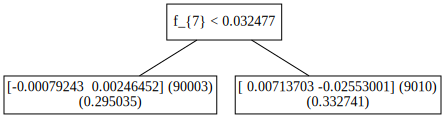

In [180]:
tree2gv(booster.forest[190][0])

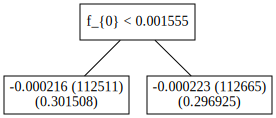

In [132]:
tree2gv(booster_regular.forest[160][0])

In [ ]:
def sigm(x):
    return 1/(1 + np.exp(-x))

In [105]:
freq = {}
for v in sigm(whole_prediction):
    freq[v] = freq.get(v, 0) + 1
freq

{0.26721492: 982,
 0.27964613: 3750,
 0.28262532: 26244,
 0.28485507: 1691,
 0.28536656: 29,
 0.28741762: 2932,
 0.28744617: 106,
 0.29536593: 5229,
 0.29722634: 20,
 0.2974511: 5,
 0.30088168: 78,
 0.3010206: 237294,
 0.3012496: 13331,
 0.3023119: 80,
 0.30651802: 2032,
 0.30738217: 1277,
 0.30917397: 4838,
 0.38645455: 5,
 0.39314502: 45,
 0.50112784: 32}

In [36]:
## xgboost

In [82]:
dmat = xgb.DMatrix((f_train > 0.5)*1, label_train)
params = {'max_depth': 1, 'objective': 'binary:logistic', 'eta': 0.03, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=300)

[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:05:15] /workspace/sr

In [83]:
all_pred = model.predict(xgb.DMatrix(full_features[:,1:2]))

In [84]:
set(all_pred)

{0.28071296, 0.30143696}

In [88]:
label_train[f_train < 0.5].mean()

0.3014155326009728

In [96]:
label_train[f_train > 0.001564].mean()

0.29691010986473404

In [99]:
np.logical_and(f_train > 0.001564, f_train < 0.5).sum()

88684